# Comparing the surface response for SciPy and PEST++ iES

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyemu
import pastas as ps
import pastas_plugins.pest as psp

%load_ext autoreload
%autoreload 2

# Load Data

In [5]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

In [6]:
pbounds = {
    "constant_d": {"initial": 27.5, "vary": False},
    "pex_A": {"pmin": 0.001, "pmax": 2500.0,},
    "pex_a": {"pmin": 0.01, "pmax": 1000.0,},
}

control_data = {
    "phiredstp": 1e-8,
    "nphistp": 25,
    "nphinored": 25,
    "relparstp": 1e-8,
}

# Create and solve model

## SciPy

Fit report head                   Fit Statistics
nfev    8                      EVP         88.64
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1231.89
tmax    2015-06-28 00:00:00    BIC      -1224.53
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (2 optimized)
               optimal     initial   vary
pex_A       866.230896  215.674528   True
pex_a       179.849683   10.000000   True
constant_d   27.500000   27.500000  False


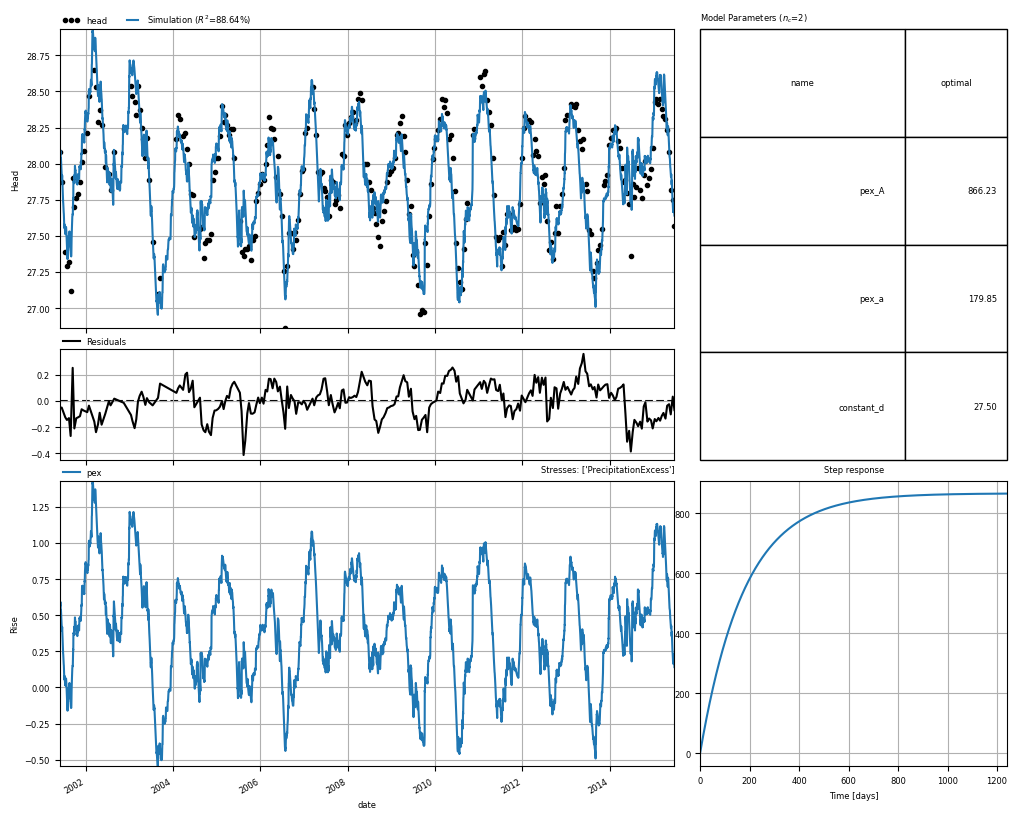

In [7]:
ml = ps.Model(head)
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)
for pname, pvars in pbounds.items():
    ml.set_parameter(pname, **pvars)
ml.solve(
    solver=ps.LeastSquares(),
    ftol=control_data["phiredstp"],
    xtol=control_data["relparstp"],
)

axes = ml.plots.results()
f = axes[0].get_figure()

f.savefig("responsesurface_model.png", dpi=600, bbox_inches="tight")

## SciPy + AR(1)

In [8]:
ml_ar = ml.copy()
ml_ar.add_noisemodel(ps.ArNoiseModel())
for pname, pvars in pbounds.items():
    ml_ar.set_parameter(pname, **pvars)
ml_ar.solve(
    solver=ps.LeastSquares(),
    ftol=control_data["phiredstp"],
    xtol=control_data["relparstp"],
)

Fit report head_copy              Fit Statistics
nfev    14                     EVP         88.58
nobs    300                    R2           0.89
noise   True                   RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1473.60
tmax    2015-06-28 00:00:00    BIC      -1462.57
freq    D                      Obj          1.08
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
                optimal     initial   vary
pex_A        870.983300  215.674528   True
pex_a        186.218405   10.000000   True
constant_d    27.500000   27.500000  False
noise_alpha   52.157531   14.000000   True


## PEST++ iES

In [11]:
ml_ies = ml.copy()
ml_ies.name = "PestIES"
solver = psp.PestIesSolver(
    exe_name="bin/pestpp-ies",
    model_ws=Path("pestf_ies/model"),
    temp_ws=Path("pestf_ies/temp"),
    master_ws=Path("pestf_ies/master"),
    noptmax=2,
    port_number=4003,
    control_data=control_data,
)
for pname, pvars in pbounds.items():
    ml_ies.set_parameter(pname, **pvars)
ml_ies.add_solver(solver)
ml_ies.solver.run_ensembles(ies_num_reals=8, ies_parameter_ensemble_method="truncnorm")

2024-09-13 17:28:18.026848 starting: opening PstFrom.log for logging
2024-09-13 17:28:18.027189 starting PstFrom process
2024-09-13 17:28:18.027229 starting: setting up dirs
2024-09-13 17:28:18.027292 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-13 17:28:18.029501 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.002209
2024-09-13 17:28:18.029570 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-13 17:28:18.030706 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.001136
2024-09-13 17:28:18.031974 finished: setting up dirs took: 0:00:00.004745
2024-09-13 17:28:18.054752 starting: adding grid type d style parameters for file(s) ['parameters_sel.

## PEST++ GLM

In [7]:
ml_glm = ml.copy()

solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm",
    model_ws=Path("pestf_glm/model"),
    temp_ws=Path("pestf_glm/temp"),
    noptmax=250,
    control_data=control_data,
)
for pname, pvars in pbounds.items():
    ml_glm.set_parameter(pname, **pvars)
ml_glm.solve(solver=solver, report=False)

2024-09-10 10:04:12.070548 starting: opening PstFrom.log for logging
2024-09-10 10:04:12.079656 starting PstFrom process
2024-09-10 10:04:12.079726 starting: setting up dirs
2024-09-10 10:04:12.079849 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-09-10 10:04:12.102829 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.022980
2024-09-10 10:04:12.102968 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-09-10 10:04:12.122668 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.019700
2024-09-10 10:04:12.129854 finished: setting up dirs took: 0:00:00.050128
2024-09-10 10:04:12.229411 starting: adding grid type d style parameters for file(s) ['parameters_sel.

# Response surface

In [8]:
def obj_func(ml: ps.Model):
    """Objective function for the Pastas model."""
    observations = ml.observations()
    sim = ml.simulate()
    residuals = (observations - sim).dropna().values
    # res_diff = (observations.diff() - sim.diff()).dropna().values
    return np.sum(residuals**2)  # + np.sum(res_diff ** 2)


A_range = np.linspace(
    ml.parameters.at["pex_A", "pmin"], ml.parameters.at["pex_A", "pmax"], 100
)
a_range = np.linspace(
    ml.parameters.at["pex_a", "pmin"], ml.parameters.at["pex_a", "pmax"], 100
)

A_mg, a_mg = np.meshgrid(A_range, a_range)

ml_rs = ml.copy()
rsurface = np.zeros((len(a_range), len(A_range)))
for i, A in enumerate(A_range):
    for j, a in enumerate(a_range):
        ml_rs.set_parameter(name="pex_A", optimal=A)
        ml_rs.set_parameter(name="pex_a", optimal=a)
        rsurface[j, i] = obj_func(ml_rs)

In [9]:
def plot_response_surface():
    norm = mpl.colors.LogNorm(rsurface.min(), rsurface.max())
    cmap = mpl.cm.cividis
    scm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    f, ax = plt.subplots(figsize=(6, 5))
    ax.pcolor(a_mg, A_mg, rsurface, norm=norm, cmap=cmap)
    ax.set_xlabel("a")
    ax.set_ylabel("A")
    f.colorbar(scm, ax=ax, label="Objective function")
    return ax

## SciPy LeastSquares trajectory

### Without AR(1) NoiseModel

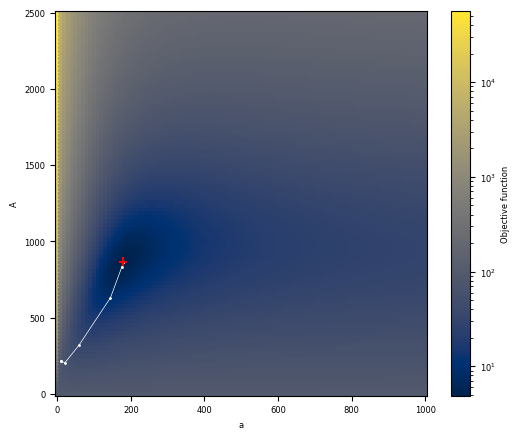

In [10]:
ax = plot_response_surface()
p_estimates = np.array(
    [[ml.parameters.loc["pex_A", "initial"], ml.parameters.loc["pex_a", "initial"]]]
    + list(np.array(ml.solver.p_estimates[2::3])[:, :2])
)
ax.plot(
    p_estimates[:, 1],
    p_estimates[:, 0],
    color="white",
    marker=".",
    markersize=2.0,
    linewidth=0.5,
)
ax.errorbar(
    ml.parameters.loc["pex_a", "optimal"],
    ml.parameters.loc["pex_A", "optimal"],
    xerr=ml.parameters.loc["pex_a", "stderr"] * 2,
    yerr=ml.parameters.loc["pex_A", "stderr"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_scipy.png", dpi=600, bbox_inches="tight")

### With AR(1) NoiseModel

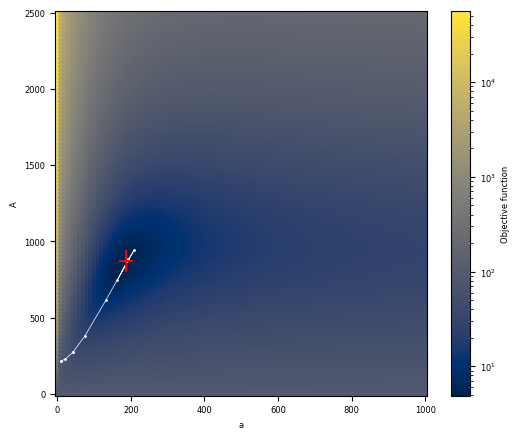

In [11]:
ax = plot_response_surface()
p_estimates = np.array(
    [
        [
            ml_ar.parameters.loc["pex_A", "initial"],
            ml_ar.parameters.loc["pex_a", "initial"],
        ]
    ]
    + list(np.array(ml_ar.solver.p_estimates[2::3])[:, :2])
)
ax.plot(
    p_estimates[:, 1],
    p_estimates[:, 0],
    color="white",
    marker=".",
    markersize=2.0,
    linewidth=0.5,
)
ax.errorbar(
    ml_ar.parameters.loc["pex_a", "optimal"],
    ml_ar.parameters.loc["pex_A", "optimal"],
    xerr=ml_ar.parameters.loc["pex_a", "stderr"] * 2,
    yerr=ml_ar.parameters.loc["pex_A", "stderr"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_scipyar.png", dpi=600, bbox_inches="tight")

## PEST++ iES trajectory

In [12]:
par_csvs = sorted(ml_ies.solver.master_ws.glob("*.par.csv"))

par_dfs = []
for par_csv in par_csvs:
    par_df = pd.read_csv(par_csv, index_col=0)
    parv = ml_ies.parameters.vary
    par_df.columns = pd.MultiIndex.from_arrays(
        ([par_csv.stem.split(".")[1]] * sum(parv), ml_ies.parameters.index[parv])
    )
    par_dfs.append(par_df)
par_dfs = pd.concat(par_dfs, axis=1).stack(level=0)

ies_ci = par_dfs.loc[(slice(None), f"{ml_ies.solver.noptmax-1}"), :].quantile(
    [0.025, 0.975], axis=0
)
ies_base = par_dfs.loc[("base", f"{ml_ies.solver.noptmax-1}"), :]
ies_err = (ies_ci - ies_base).abs()

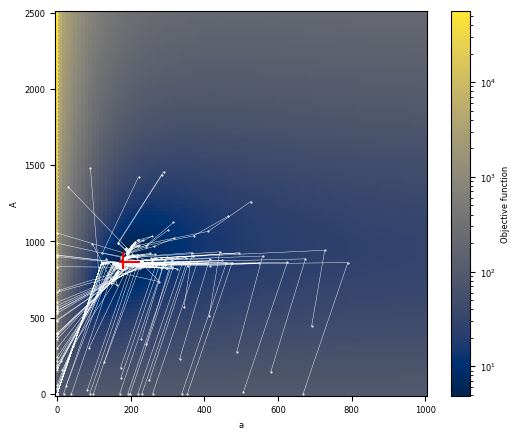

In [13]:
ax = plot_response_surface()
for idx in np.unique(par_dfs.index.get_level_values(0)):
    par_i = par_dfs.loc[idx, :]
    ax.plot(
        par_i.loc[:, "pex_a"],
        par_i.loc[:, "pex_A"],
        color="white",
        marker=".",
        markersize=1.0,
        linewidth=0.3,
    )
ax.errorbar(
    ies_base.at["pex_a"],
    ies_base.at["pex_A"],
    xerr=ies_err.loc[:, ["pex_a"]].values,
    yerr=ies_err.loc[:, ["pex_A"]].values,
    color="red",
)
ax.get_figure().savefig("responsesurface_ies.png", dpi=600, bbox_inches="tight")

## PEST++ GLM trajectory

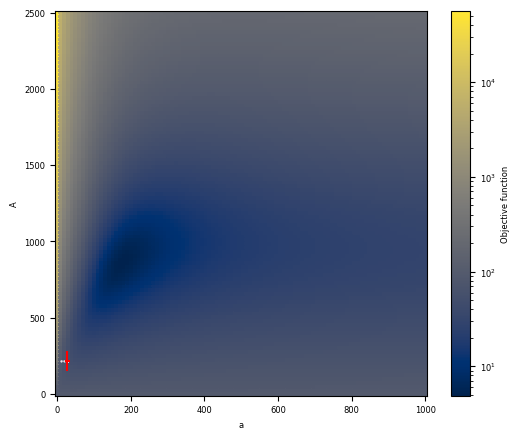

In [14]:
par_usum = pd.read_csv(
    ml_glm.solver.temp_ws / "pest.par.usum.csv", index_col=0
).set_index(ml_glm.parameters.index[ml_glm.parameters.vary])
ipar = (
    pd.read_csv(ml_glm.solver.temp_ws / "pest.ipar", index_col=0)
    .transpose()
    .set_index(ml_glm.parameters.index[ml_glm.parameters.vary])
    .transpose()
)

ax = plot_response_surface()
ax.plot(
    ipar.loc[:, "pex_a"],
    ipar.loc[:, "pex_A"],
    color="white",
    marker=".",
    markersize=1.0,
    linewidth=0.3,
)
ax.errorbar(
    par_usum.at["pex_a", "post_mean"],
    par_usum.at["pex_A", "post_mean"],
    xerr=par_usum.at["pex_a", "post_stdev"] * 2,
    yerr=par_usum.at["pex_A", "post_stdev"] * 2,
    color="red",
)
ax.get_figure().savefig("responsesurface_glm.png", dpi=600, bbox_inches="tight")

# Jacobian

In [179]:
jac_ls = pd.DataFrame(ml.solver.result.jac, index=ml.observations().index, columns=ml.parameters.index[ml.parameters.vary])
jac_ar = pd.DataFrame(ml_ar.solver.result.jac, index=ml_ar.observations().index, columns=ml_ar.parameters.index[ml_ar.parameters.vary])
jac_glm = pyemu.Jco.from_binary(ml_glm.solver.temp_ws / "pest.jcb").df().transpose().set_index(ml_glm.parameters.index[ml_glm.parameters.vary]).transpose()

# jac_ies needs to be calculated manually
obs_ies = pd.read_csv(ml_ies.solver.master_ws / "pest.10.obs.csv", index_col=0).transpose()
dsim = ((obs_ies - obs_ies.mean()) / np.sqrt(len(obs_ies) - 1)).values
par_ies = pd.read_csv(ml_ies.solver.master_ws / "pest.10.par.csv", index_col=0)
dpar = ((par_ies - par_ies.mean()) / np.sqrt(len(par_ies) - 1)).values
# dpar_inv = - (np.linalg.inv(dpar.T @ dpar) @ dpar.T).T
dpar_inv = -np.linalg.pinv(dpar).T
jac_ies = pd.DataFrame(dsim @ dpar_inv, index=ml_ies.observations().index, columns=ml_ies.parameters.index[ml_ies.parameters.vary])

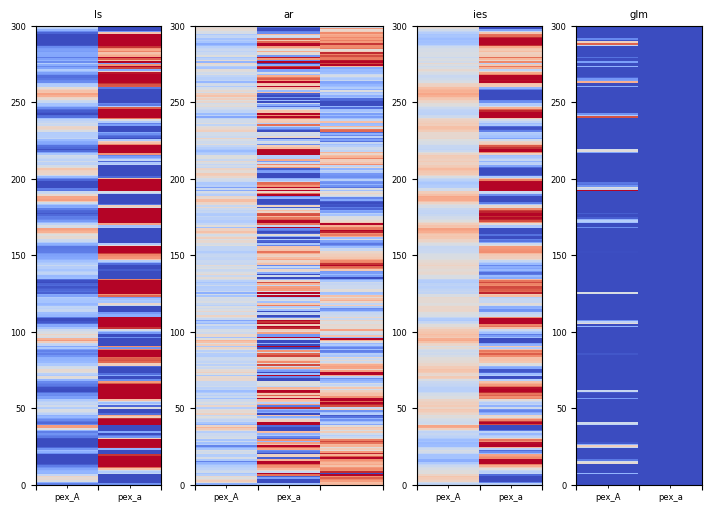

In [180]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)

f, axd = plt.subplot_mosaic([["ls", "ar", "ies", "glm"]], figsize=(7, 5), constrained_layout=True, width_ratios=[2,3,2,2])
axd["ls"].pcolor(jac_ls, cmap=cmap, norm=norm)
axd["ar"].pcolor(jac_ar, cmap=cmap, norm=norm)
axd["ies"].pcolor(jac_ies, cmap=cmap, norm=norm)
axd["glm"].pcolor(jac_glm.values, cmap=cmap, norm=norm)

for k in axd:
    axd[k].set_title(k)
    axd[k].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    axd[k].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    axd[k].set_xticklabels([], minor=False)
    axd[k].set_xticks(np.arange(len(jac_glm.columns)) + 0.5, minor=True)
    axd[k].set_xticklabels([x for x in jac_glm.columns], minor=True)